# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #6


*   Youtube Lecture #23-26
*   Written by Seungeun Lee

## 3. Image Classification w/ pre-trained ResNet model -- custom dataset
*     Custom dataset: https://www.kaggle.com/datasets/jiweiliu/hymenoptera-data
*     Download the dataset and unzip it as always.



*    Reference. https://github.com/Justin-A/DeepLearning101/blob/master/4-6_Transfer_Learning.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/intro-dl/hymenoptera

/content/drive/MyDrive/intro-dl/hymenoptera


In [3]:
!unzip archive.zip

Archive:  archive.zip
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/1473187633_63ccaacea6.jpg  
  inflating: hymenoptera_data/train/ants/148715752_302c84f5a4.jpg  
  inflating: hymenoptera_data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [5]:
# 런타임 - 런타임 유형 변경 - T4 GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1+cu121  Device: cuda


In [6]:
BATCH_SIZE = 32
EPOCHS = 10

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("/content/drive/MyDrive/intro-dl/hymenoptera/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']} ## Change Here! (Your directory)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, shuffle = True) for x in ['train', 'val']}


In [8]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [9]:
y_train

tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 0])

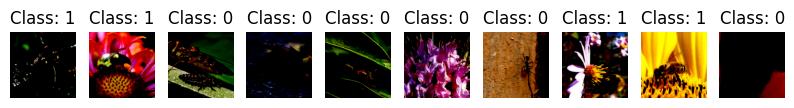

In [10]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [11]:
import torchvision.models as models
model = models.resnet34(pretrained = True) # Load ResNet34 model w/ pre-trained weight. if False, then we only load the architeture of ResNet34, not the pre-trained weights.
print(model) # print the model architecture -- default ResNet34 model (pre-trained w/ Imagenet Dataset) has final 1000 output nodes
# BUT we have 2 classes in our custom dataset!!

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 126MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
## IMPORTANT: There are 2 ways to use pre-trained models

# (1) NOT updating the weights of the pre-trained models, and use the model as it is
for parameter in model.parameters():
    parameter.requires_grad = False # We previously learned the requires_grad means utilizing backpropagation

# (2) Updating the weights of the pre-trained mdoels
# for parameter in model.parameters():
#     parameter.requires_grad = True

# We usually use method #1 when using pre-trained models, but it's not the 100% perfect answer -- sometimes method #2 works better
# The optimal solution may vary according to the dataset or other techniques such as learning rate, optimizer, and so on

num_ftrs = model.fc.in_features # To mitigate the issues of the final layer, we should add one more layer having final 2 output nodes
model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1),
            nn.Sigmoid()
        ) # Add such layer!

model = model.to(DEVICE)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image).squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [15]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE, dtype=torch.float)
            label = label.to(DEVICE, dtype=torch.float)
            output = model(image).squeeze(dim=1)
            test_loss += criterion(output, label).item()
            output1 = output.cpu()
            output1[output1 >= 0.5] = 1
            output1[output1 < 0.5] = 0
            correct += output1.eq(label.cpu()).int().sum()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [16]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.691575
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.752876
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.805542

[EPOCH: 1], 	Test Loss: 0.7098, 	Test Accuracy: 60.96 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.701037
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.835746
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.543214

[EPOCH: 2], 	Test Loss: 0.7111, 	Test Accuracy: 63.22 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.737474
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.686672
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.698983

[EPOCH: 3], 	Test Loss: 0.7065, 	Test Accuracy: 62.72 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.654428
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.580433
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.637282

[EPOCH: 4], 	Test Loss: 0.7049, 	Test Accuracy: 59.19 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.610256
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.618458
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.755300

### Question 1. Compare & Contrast the test result (accuracy) of requires_grad = False & True.


In [17]:
model = models.resnet34(pretrained = True)

for parameter in model.parameters():
    parameter.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1),
            nn.Sigmoid()
        )

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.786451
Train Epoch: 1 [160/397 (38%)]	Train Loss: 1.114206
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.692659

[EPOCH: 1], 	Test Loss: 19.0321, 	Test Accuracy: 51.89 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.673925
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.642172
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.689426

[EPOCH: 2], 	Test Loss: 0.7045, 	Test Accuracy: 60.96 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.703636
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.703189
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.650689

[EPOCH: 3], 	Test Loss: 6.6165, 	Test Accuracy: 54.16 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.664247
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.725854
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.762187

[EPOCH: 4], 	Test Loss: 1.3581, 	Test Accuracy: 61.96 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.590042
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.738087
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.69984

## 성능이 비슷한 것을 확인할 수 있다.

### Question 2. Change the model ResNet34 to ResNet50 and run the entire code. Compare & Contrast the results of those two models.


In [18]:
model = models.resnet50(pretrained = True)

for parameter in model.parameters():
    parameter.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1),
            nn.Sigmoid()
        )

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.687787
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.608756
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.951913

[EPOCH: 1], 	Test Loss: 0.7180, 	Test Accuracy: 53.40 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.668365
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.690473
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.685726

[EPOCH: 2], 	Test Loss: 0.6855, 	Test Accuracy: 61.46 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.695406
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.667015
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.735973

[EPOCH: 3], 	Test Loss: 0.6858, 	Test Accuracy: 61.46 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.660318
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.629351
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.674587

[EPOCH: 4], 	Test Loss: 0.6592, 	Test Accuracy: 64.23 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.587160
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.653994
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.885643

## Resnet34를 썼을 때보다 성능이 더 높은 것을 확인할 수 있다.

### Question 3. Change the model ResNet34 to Inceptionv3 or v4 and run the entire code. Compare & Contrast the results of those two models.

In [19]:
model = models.inception_v3(pretrained = True)

for parameter in model.parameters():
    parameter.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1),
            nn.Sigmoid()
        )

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5) # 무엇이 문제인지는 알겠으나 어떻게 해결을 해야 할지 모르겠습니다ㅠㅠ
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 62.6MB/s]


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

### Question 4. Compare & Contrast the test result (accuracy) of pretrained=False & True. (models.resnet34(pretrained = True))

In [20]:
model = models.resnet34(pretrained = False)

for parameter in model.parameters():
    parameter.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1),
            nn.Sigmoid()
        )

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.723121
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.727171
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.660086

[EPOCH: 1], 	Test Loss: 0.6969, 	Test Accuracy: 61.46 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.591473
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.854555
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.644505

[EPOCH: 2], 	Test Loss: 0.7134, 	Test Accuracy: 61.96 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.716998
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.653791
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.746927

[EPOCH: 3], 	Test Loss: 0.7115, 	Test Accuracy: 61.46 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.613454
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.652164
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.690309

[EPOCH: 4], 	Test Loss: 0.7085, 	Test Accuracy: 61.21 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.660929
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.684367
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.689108

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment6

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60